# Book Recommendations

This notebook explores a dataset of book recommendations, attempting to create a recommendation tool based on similarities between descriptions.

The notebook focuses on three questions:

1. **What are the most frequent words in descriptions?**

    The most frequent words in book descriptions (once stop words have been removed) are those that have the least importance and discriminating power, as they will not distinguish one book from another effectively. Being able to identify these words could help authors and publishers write more useful book descriptions, avoiding words that are essentially filler terms.


2. **Can TF-IDF effectively distinguish between separate books based solely on descriptions?**

    Book descriptions are often short and may share significant vocabulary, particularly after cleaning and processing text to reduce dimensionality. There's no point in building a recommendation system based upon TF-IDF if the book descriptions, after cleaning, are not sufficiently distinct.


3. **Can book descriptions alone be used to make reasonable recommendations?**

    Recommendation systems are used in all sorts of customer-facing contexts; being able to recommend products to consumers based on their past behaviour or interests has obvious implications in terms of boosting sales and/or customer engagement.

## Importing libraries

In [1]:
import pandas as pd  # Dataframes
import re  # Regular expressions
from langdetect import detect  # Detect the language of text
from nltk.tokenize import word_tokenize  # Split text into words
from nltk.corpus import stopwords  # Lists of unimportant words
from collections import Counter, defaultdict  # Count word frequency & provide more versatile dicts
from pandas.core.common import flatten  # Collapse lists of lists
from nltk.stem.wordnet import WordNetLemmatizer  # Reduce terms to their root
from nltk import pos_tag  # Tag words with parts of speech
import seaborn as sns  # Visualisations
import matplotlib.pyplot as plt  # Visualisations
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to TF-IDF representations
from sklearn.metrics.pairwise import cosine_similarity  # Check similarities between vectors

## Data sourcing

Data for this project is sourced from a dataset of popular books on [Kaggle](https://www.kaggle.com/meetnaren/goodreads-best-books).

In [2]:
books = pd.read_csv("book_data.csv")

## Data exploration & cleaning

In [3]:
# View the raw data

books.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [4]:
# Check the size of the dataframe

books.shape

(54301, 12)

In [5]:
# Keep only columns that are relevant to the current analysis

books = books[["book_title", "book_authors", "book_desc"]]

In [6]:
# Rename the columns

books.columns = ["title", "author", "description"]

In [7]:
# Keep only the first author for any book - a crude method, but focuses on the probable main author

books.loc[:, "author"] = books["author"].str.split("|").str[0]

In [8]:
# Check the data

books.head()

,title,author,description
0,The Hunger Games,Suzanne Collins,Winning will make you famous. Losing means cer...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,There is a door at the end of a silent corrido...
2,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...
3,Pride and Prejudice,Jane Austen,«È cosa ormai risaputa che a uno scapolo in po...
4,Twilight,Stephenie Meyer,About three things I was absolutely positive.F...


In [9]:
# Look at the most popular authors

books.groupby("author").count() \
                       .sort_values(by="title", ascending=False)["title"][:10]

author
Stephen King          180
Cassandra Clare       118
Anonymous             115
Nora Roberts          107
Terry Pratchett       106
Agatha Christie       105
James Patterson        97
Neil Gaiman            89
Rick Riordan           84
George R.R. Martin     84
Name: title, dtype: int64

The high number of titles suggests that some authors have duplicate titles - perhaps different editions or translations. The next step is to detect and remove those duplicates.

In [10]:
# Replace any missing descriptions with an empty string

books.loc[:, "description"].fillna("", inplace=True)

# Select just the descriptions

descriptions = books["description"]

# Apply processing to the descriptions to simplify and remove awkward characters

descriptions = descriptions.str.lower() \
                           .str.replace("[^a-z ]", " ") \
                           .str.replace(r"\s+", " ")

# Overwrite the original descriptions

books.loc[:, "description"] = descriptions

# Drop any rows with missing or very short descriptions (<=100 characters)

books = books[books["description"].apply(len) > 100]

# Drop any rows with duplicate descriptions

books = books.drop_duplicates(subset=["description"])

In [11]:
# Identify the language of each description; this code takes a while to run

books.loc[:, "language"] = books["description"].apply(detect)

In [12]:
# For simplicity, drop all non-English books

books = books[books["language"] == "en"]

# Drop the now-superfluous language column

books.drop("language", axis=1, inplace=True)

In [13]:
books.head()

,title,author,description
0,The Hunger Games,Suzanne Collins,winning will make you famous losing means cert...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,there is a door at the end of a silent corrido...
2,To Kill a Mockingbird,Harper Lee,the unforgettable novel of a childhood in a sl...
4,Twilight,Stephenie Meyer,about three things i was absolutely positive f...
5,The Book Thief,Markus Zusak,trying to make sense of the horrors of world w...


In [14]:
# Drop everything from each title after a breaking point (dash, bracket, colon, slash)
# This is a somewhat crude measure that will deal with omnibuses and different edition titles

books.loc[:, "title"] = books["title"].apply(lambda title: re.split(":|\(| - |/", title)[0].strip())

# Drop everything with a title that implies multiple works in one book

books = books[~books["title"].str.lower().str.contains("omnibus|box set|boxed set|compilation|collection")]

There may be many books with slight differences in titles, or with titles in another language although the description is in English. We need to remove as many of those as possible.

In [15]:
# Add another column for matching titles, in lowercase

books["clean_title"] = books["title"].str.lower().str.strip()

# Remove punctuation, etc. from the title

books.loc[:, "clean_title"] = books["clean_title"].str.replace("[^a-z ]", " ") \
                                                  .str.replace(r"\s+", " ")

# Drop rows with an empty/very short clean_title column

books.loc[:, "clean_title"] = books["clean_title"].fillna("")

books = books[books["clean_title"].apply(len) >= 2]

In [16]:
# Drop all books with duplicate titles

books = books.drop_duplicates(subset=["title"])

books = books.drop_duplicates(subset=["clean_title"])

# Drop now-superfluous columns

books = books.drop(columns=["clean_title"])

In [17]:
# Check the new shape of the dataframe

books.shape

(37514, 3)

In [18]:
# Look at the most popular authors

books.groupby("author").count() \
                       .sort_values(by="title", ascending=False)["title"][:10]

author
James Patterson    77
Nora Roberts       75
Stephen King       72
Anonymous          69
Agatha Christie    68
Terry Pratchett    61
Francine Pascal    60
Carolyn Keene      56
J.D. Robb          52
Meg Cabot          51
Name: title, dtype: int64

We've now got a much more reasonable series of numbers for most popular authors.

In [19]:
# Output overview figures

print(f"The dataset contains {books.shape[0]} different books by {books['author'].nunique()} different authors.")

The dataset contains 37514 different books by 17091 different authors.


In [20]:
# Reset the index to be sequential again

books.reset_index(drop=True, inplace=True)

In [21]:
# View the data

books.head()

,title,author,description
0,The Hunger Games,Suzanne Collins,winning will make you famous losing means cert...
1,Harry Potter and the Order of the Phoenix,J.K. Rowling,there is a door at the end of a silent corrido...
2,To Kill a Mockingbird,Harper Lee,the unforgettable novel of a childhood in a sl...
3,Twilight,Stephenie Meyer,about three things i was absolutely positive f...
4,The Book Thief,Markus Zusak,trying to make sense of the horrors of world w...


## Saving the cleaned data

The above processing stages take a lot of time, so to save time in future, we'll write the dataframe to a file now.

In [22]:
books.to_csv("books.csv", index=False)

In [23]:
# Load the data in from a file

books = pd.read_csv("books.csv")

In [24]:
books.sample(10)

,title,author,description
17451,The Adventures of Dwarfgiants,Steven Jacklin,driven from kamistra their island home the dwa...
29691,From Texas with Love,Dan Gutman,the wackiest road trip in history continues in...
35113,Jesus Always,Sarah Young,sarah young s first day devotional since jesus...
19367,Clea,Lawrence Durrell,the magnificent final volume of one of the mos...
21365,The Cheese Monkeys,Chip Kidd,after years of designing more than book jacket...
4954,Iphigenia in Aulis,Euripides,agamemnon s sacrifice of his daughter in order...
23595,Hick,Andrea Portes,foreseeing a hopeless future in barrooms and p...
2308,All Over But the Shoutin',Rick Bragg,the story of a violent war haunted alcoholic f...
37157,The Christmas Knight,Michele Sinclair,her only hope for the seasonwith their father ...
6143,Shades of Twilight,Linda Howard,roanna davenport was raised a wealthy orphan o...


## Pre-processing

Although the data is now cleaned, it still needs some processing to make sure that analysis of the descriptions is meaningful. This process will focus on reducing the dimensionality of the words.

In [25]:
# Select just the descriptions

descriptions = books["description"]

# Split words into tokens

descriptions = descriptions.apply(word_tokenize)

The first step is to *lemmatize* the descriptions - to reduce each word to its dictionary form. This reduces dimensionality.

In [26]:
# Create a dictionary to map tags to ones that the lemmatiser will understand.

tag_map = defaultdict(lambda : "n")  # by default, assume nouns
tag_map['J'] = "a"  # adjectives
tag_map['V'] = "v"  # verbs
tag_map['R'] = "r"  # adverbs

# Create a function to get the pos tags for a set of tokens, and return the tokens in a way a
# lemmatizer can interpret
def get_wordnet_tags(tokens):
    """Returns WordNet pos_tags for a set of tokens"""
    
    # Tag tokens with pos_tagger
    tagged_tokens = pos_tag(tokens)
    
    # Convert each tag to a version wordnet can understand
    tagged_tokens = [(token[0], tag_map[token[1][0]]) for token in tagged_tokens]
    
    return tagged_tokens
    
    return tokens

# Create a lemmatizing object

lemma = WordNetLemmatizer()

In [27]:
# Tag each token in each description

descriptions = descriptions.apply(get_wordnet_tags)

# Lemmatize the sets of tokens; this code takes a while to run

descriptions = descriptions.apply(lambda tokens: [lemma.lemmatize(word=token[0],
                                                                  pos=token[1])
                                                  for token in tokens])

The next stage is to reduce the number of terms by removing small functional words.

In [28]:
# Get a list of stopwords

stops = stopwords.words("english")

# Filter out all stopwords and words less than 3 letters long from the descriptions.

descriptions = descriptions.apply(lambda tokens: [word for word in tokens
                                                  if word not in stops
                                                  and len(word) > 2])

## Question 1 - what are the most frequent words in descriptions?

In [29]:
# Join all the descriptions together into a list of lists

tokens = descriptions.to_list()

# Flatten the lists

tokens = flatten(tokens)

# Count each unique word

token_counts = Counter(tokens)

# Convert the counter dict into a sortable series

token_counts = pd.Series(token_counts)

In [30]:
# View the top ten terms

token_counts.sort_values(ascending=False, inplace=True)

token_counts.head(10)

life     24904
one      22398
new      16413
world    16205
love     15412
find     14263
book     14201
story    13491
time     13336
year     13182
dtype: int64

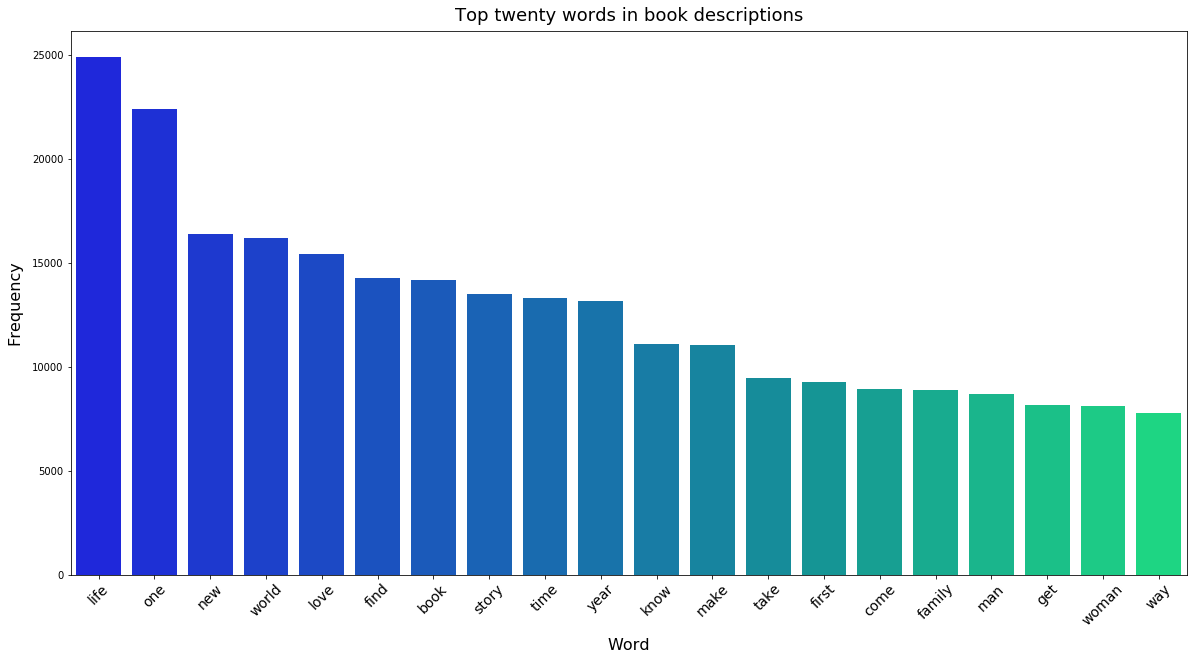

In [31]:
# Extract the top twenty terms

top_twenty = token_counts.head(20)

# Plot the top twenty as a bar chart

plt.figure(figsize=(20, 10))
plt.xticks(fontsize=14, rotation=45)
plt.ylabel("Frequency", fontsize=16, labelpad=10)
plt.xlabel("Word", fontsize=16, labelpad=10)
plt.title("Top twenty words in book descriptions",
          fontsize=18, pad=10)

sns.barplot(x=top_twenty.index, y=top_twenty,
            palette="winter")

## Modelling

In order to identify similar books, we'll use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) as a way to determine key terms in each description.

In [32]:
# Join the tokens back into strings

descriptions = descriptions.apply(lambda text: " ".join(text))

In [33]:
# Create a tfidf vectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=0.01)

In [34]:
# Create a document-term matrix using the vectorizer

description_dtm = tfidf_vectorizer.fit_transform(descriptions)

In [35]:
# View the dtm

description_dtm

<37514x1261 sparse matrix of type '<class 'numpy.float64'>'
	with 1586856 stored elements in Compressed Sparse Row format>

## Question 2: can TF-IDF vectors effectively distinguish between different documents?

A recommendation engine will fail - but look like it's succeeding - if it can't effectively distinguish between different books. It will find similarites, but they won't be meaningful, because it won't have picked up on dissimilarities.

In [36]:
# Convert the DTM to a dataframe

vectors = pd.DataFrame(columns=tfidf_vectorizer.get_feature_names(),
                       data=description_dtm.A)

In [37]:
# Find all the rows with at least one duplicate

duplicates = vectors[vectors.duplicated(keep=False)]

In [38]:
# Match up the duplicates by sorting based on all columns

duplicates = duplicates.sort_values(by=list(duplicates.columns)).index

# Select the duplicated rows as a new dataframe

duplicate_df = books.iloc[list(duplicates)].copy()

In [39]:
# Output key figures

print(f"The dataset contains {duplicate_df.shape[0]} different books by {duplicate_df['author'].nunique()} different authors.")
print(f"There are {duplicate_df['description'].nunique()} distinct descriptions.")

The dataset contains 24 different books by 16 different authors.
There are 24 distinct descriptions.


In [40]:
duplicate_df

,title,author,description
30060,Broca's Brain,Carl Sagan,carl sagan writer scientist returns from the f...
34213,O Cérebro de Broca,Carl Sagan,pre isbncarl sagan writer and scientist return...
850,The Taming of the Shrew,William Shakespeare,the arden shakespeare is the established editi...
16677,Timon of Athens,William Shakespeare,the arden shakespeare is the established editi...
26188,All The Rivers Run,Nancy Cato,free delivery if order value from the seller i...
34744,Michael Morpurgo Escape from Shangri-La,Michael Morpurgo,free shipping if order value from the seller i...
16656,In the Land of the Living Dead,Prentiss Tucker,many of the earliest books particularly those ...
20824,Der Teufel In Frankreich. Erlebnisse,Lion Feuchtwanger,many of the earliest books particularly those ...
4621,Beneath the Wheel,Hermann Hesse,in hermann hesse s beneath the wheel or the pr...
26146,The Prodigy,Hermann Hesse,in hermann hesse s beneath the wheel or the pr...


In the final analysis, only 24 duplicates were found: 24 books with TF-IDF vectors that were identical to another book's description. These books all had extremely similar descriptions, so it is not surprising that the vectors were the same. The problem here is in the data, not the metrics: some books have non-specifc descriptions.

Overall, TF-IDF sufficiently differentiates between different books, with only very minor confusion. This means that is a viable choice for building the recommendation system.

## Calculate similarities for a document

Once we have the document-term matrix of TF-IDF scores, we can calculate the similarity between books by looking for similarities in their TF-IDF vectors. To do this, we need the `cosine_similarity` score.

As a test description, we'll use [Steve Alten's *Meg*](https://www.goodreads.com/book/show/105744.Meg) to check our recommendations. One edition of *Meg* is already in the dataset, so we should get at least one result.

In [41]:
# Create a function that processes a text description into the same format as the provided descriptions

def convert_text_to_vector(text):
    
    # Clean text
    text = text.lower()
    text = re.sub("[^a-z ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Lemmatize and remove stopwords
    text = text.split(" ")
    text = get_wordnet_tags(text)
    text = [lemma.lemmatize(word=word[0], pos=word[1]) for word in text]
    text = [word for word in text if word not in stops and len(word) > 3]
    text = " ".join(text)
    
    # Convert the description to a TF-IDF vector
    vector = tfidf_vectorizer.transform([text])
    
    return vector

In [42]:
# Example description string 

test_description = """On a top-secret dive into the Pacific Ocean's deepest canyon,
                      Jonas Taylor found himself face-to-face with the largest and
                      most ferocious predator in the history of the animal kingdom.
                      The sole survivor of the mission, Taylor is haunted by what
                      he's sure he saw but still can't prove exists - Carcharodon
                      megalodon, the massive mother of the great white shark. The
                      average prehistoric Meg weighs in at twenty tons and could
                      tear apart a Tyrannosaurus rex in seconds. Taylor spends years
                      theorizing, lecturing, and writing about the possibility that
                      Meg still feeds at the deepest levels of the sea. But it takes
                      an old friend in need to get him to return to the water, and a
                      hotshot female submarine pilot to dare him back into a high-tech
                      miniature sub. Diving deeper than he ever has before, Taylor will
                      face terror like he's never imagined. MEG is about to surface.
                      When she does, nothing and no one is going to be safe, and Jonas
                      must face his greatest fear once again."""

# Convert the test description to a vector 

query_vector = convert_text_to_vector(test_description)

In [43]:
query_vector

<1x1261 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [44]:
# Use cosine similarity to find the most similar vectors to the test

similarities = cosine_similarity(query_vector, description_dtm).flatten()

## Question 3 - can we make reasonable recommendations?

Now that we can calculate similarities between book descriptions, we can simply match those similarities back to the books and return the authors & titles of the books with the highest scores.

In [45]:
# Take a copy of books to match scores against

recommendation_df = books[["author", "title"]].copy()

# Add the similarity scores as another column

recommendation_df["similarity"] = similarities

# Sort the dataframe by similarity

recommendation_df.sort_values(by="similarity", ascending=False, inplace=True)

# Output the top ten recommendations

recommendation_df.head(10)

,author,title,similarity
17147,Steve Alten,Meg,0.960885
25681,Maud Hart Lovelace,Emily of Deep Valley,0.306204
21612,Judith Reeves-Stevens,The Fall of Terok Nor,0.263083
2445,Alyson Noel,Night Star,0.261695
22891,R.W. Ridley,The Gore,0.260723
8533,Dani Pettrey,Submerged,0.251148
10868,Julia Golding,Secret of the Sirens,0.248845
5572,Helen Dunmore,The Deep,0.247202
26120,Chris Heimerdinger,Tower of Thunder,0.237470
8414,Maud Hart Lovelace,Carney's House Party,0.235357


It worked! The most similar book to *Meg* is *Meg*, which shows that our recommender is working. The other books suggested are generally reasonable ones; for example, *Submerged* by Dani Pettrey is also about horror in the depths.

*Emily of Deep Valley* is not particularly similar in tone or theme, but both books have the word "deep" frequently in their descriptions. This shows one weakness of TF-IDF; it picks up on relative word importance, but struggles with words being used in different contexts.

We have successfully built a recommendation system, though it does still have flaws. Potential refinements would be

1. Consider genre, and only recommend books in a similar category, even if highly similar
2. Remove named entities as a processing step; character names are frequent in descriptions but don't suggest anything about themes etc.
3. Use longer text - descriptions might not have much discerning power compared to reviews or actual excerpts.

## Recommendation tool

The next cell is an all-in-one recommendation engine: enter a description in the provided text box, and see a list of recommended other books.

In [46]:
# Prompt the user for a description

book_description = input("Enter a book description: ")

# Process the description

query_vector = convert_text_to_vector(book_description)

# Calculate similarities

similarities = cosine_similarity(query_vector, description_dtm).flatten()

# Take a copy of books to match scores against

recommendation_df = books[["author", "title"]].copy()

# Add the similarity scores as another column

recommendation_df["similarity"] = similarities

# Sort the dataframe by similarity

recommendations = recommendation_df.sort_values(by="similarity",
                                                ascending=False).reset_index(drop=True).head(5)

# Output formatted recommendations

print("--------------------------------------------------------------\nBased on that description, your top 5 recommendations are")
for book in recommendations.iterrows():
    print(f"{book[0] + 1}. {book[1]['title']}, by {book[1]['author']}")

Enter a book description: The war is over, and army priest Tomas Piety heads home with Sergeant Bloody Anne at his side. But things have changed while he was away: his crime empire has been stolen and the people of Ellinburg--his people--have run out of food and hope and places to hide. Tomas sets out to reclaim what was his with help from Anne, his brother, Jochan, and his new gang: the Pious Men. But when he finds himself dragged into a web of political intrigue once again, everything gets more complicated.  As the Pious Men fight shadowy foreign infiltrators in the back-street taverns, brothels, and gambling dens of Tomas's old life, it becomes clear: The war is only just beginning.
--------------------------------------------------------------
Based on that description, your top 5 recommendations are
1. Born, by A.E. Watson
2. Treasure, by S.  Smith
3. There's No Place Like Here, by Cecelia Ahern
4. Reaper's Gale, by Steven Erikson
5. Tokyo Crazy Paradise, Vol. 1, by Yoshiki Nakamu